# MNIST - Handwriting Recognition

In [1]:
from DisplayUtils import show_df

## Training Data

In [2]:
df = sqlCtx.read.parquet('/home/mridul/bigml/caffe/data/mnist_test_dataframe/')

In [3]:
show_df(df)

Index,Label,Image
00005000,3,
00005001,9,
00005002,9,
00005003,8,
00005004,4,
00005005,1,
00005006,0,
00005007,6,
00005008,0,
00005009,9,


# MNIST Neural Network

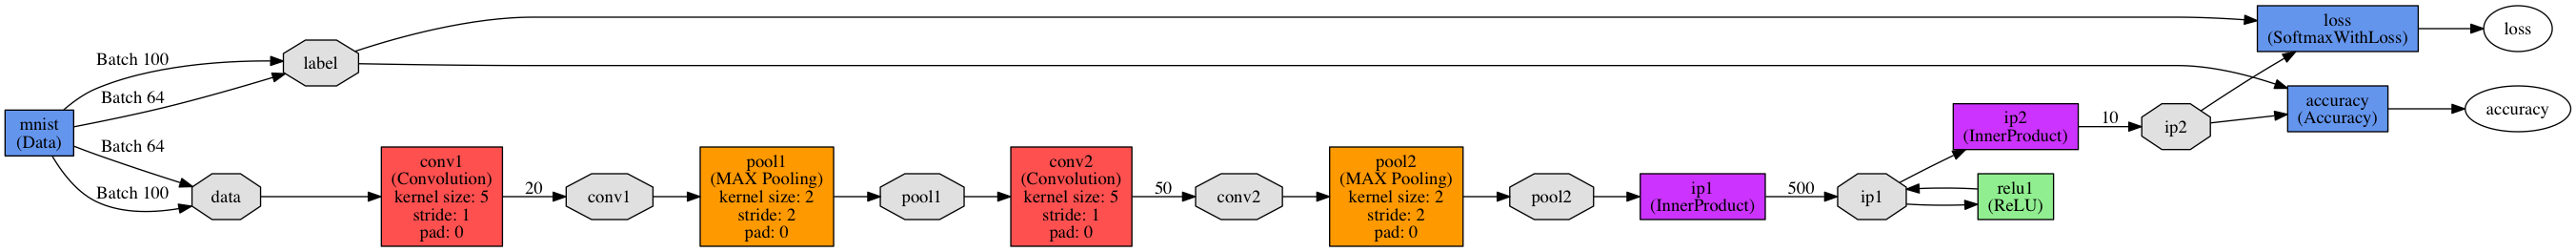

In [4]:
from IPython.display import Image
Image(filename='/home/mridul/bigml/demodl/network/mnist.png') 


# Training

In [5]:
from CaffeOnSpark import *
from Config import *
from DataSource import *
from pyspark.sql import DataFrame
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row

In [6]:
cos=CaffeOnSpark(sc,sqlContext)

In [3]:
args={}
args['-conf']='/home/mridul/bigml/caffe/data/lenet_dataframe_solver.prototxt'
args['-model']='file:///home/mridul/lenet.model'
args['-label']='label'
args['-output']='file:outputlenet'
args['-devices']='1'
args['-outputFormat']='json'
args['-train']='True'

In [4]:
cfg=Config(sc,args)
dl_train_source = DataSource(sc).getSource(cfg,True)


NameError: name 'Config' is not defined

In [5]:
cos.train(dl_train_source)

# Test

In [19]:
#args={}
#args['-conf']='/home/mridul/bigml/caffe/data/lenet_dataframe_solver.prototxt'
#args['-model']='file:/home/mridul/lenet.model'
#args['-label']='label'
#args['-output']='file:outputlenet'
#args['-devices']='1'
#args['-outputFormat']='json'
#args['-test']='True'

In [7]:
cfg=Config(sc)
cfg.protoFile='/home/mridul/bigml/caffe/data/lenet_dataframe_solver.prototxt'
cfg.modelPath = 'file:/home/mridul/lenet.model'
cfg.label = 'label'
cfg.outputPath = 'file:outputlenet'
cfg.devices = 1
cfg.outputFormat = 'json'
cfg.isTest = True
cfg.clusterSize = 1

Traceback (most recent call last):
  File "/tmp/spark-9d1b688e-21a9-4f2c-b235-67dc6b9dd524/userFiles-1b64f242-e09b-4419-8821-487188b91c88/caffeonsparkapi.zip/ConversionUtil.py", line 617, in callJavaMethod
    return javaInstance(*_getConvertedTuple(args,sym,defaults,mirror))
  File "/tmp/spark-9d1b688e-21a9-4f2c-b235-67dc6b9dd524/userFiles-1b64f242-e09b-4419-8821-487188b91c88/caffeonsparkapi.zip/ConversionUtil.py", line 604, in _getConvertedTuple
    convertedList.append(defaults[-argDifference+i])
IndexError: list index out of range


In [8]:
dl_test_source = DataSource(sc).getSource(cfg,False)

In [9]:
test_result=cos.test(dl_test_source)


In [10]:
test_result

{u'accuracy': [0.9896000057458878], u'loss': [0.029420489565090975]}

# Feature Extraction

In [11]:
args['-conf']='/home/mridul/bigml/caffe/data/lenet_dataframe_solver.prototxt'
args['-model']='file:/home/mridul/lenet.model'
args['-features']='accuracy,ip2'
args['-label']='label'
args['-output']='file:outputlenet'
args['-devices']='1'
args['-outputFormat']='json'

In [12]:
cfg=Config(sc,args)
dl_features_source = DataSource(sc).getSource(cfg,False)

In [13]:
f=cos.features(dl_features_source)

In [14]:
f.show(10)


+--------+--------+--------------------+-----+
|SampleID|accuracy|                 ip2|label|
+--------+--------+--------------------+-----+
|00005000|   [1.0]|[-6.6938324, -4.3...|[3.0]|
|00005001|   [1.0]|[-5.6929913, -7.2...|[9.0]|
|00005002|   [1.0]|[-5.7649927, -7.6...|[9.0]|
|00005003|   [1.0]|[-6.02533, -7.319...|[8.0]|
|00005004|   [1.0]|[-5.310922, -2.56...|[4.0]|
|00005005|   [1.0]|[-1.5654247, 13.9...|[1.0]|
|00005006|   [1.0]|[15.14268, -2.279...|[0.0]|
|00005007|   [1.0]|[3.4812944, -5.75...|[6.0]|
|00005008|   [1.0]|[15.894955, -4.28...|[0.0]|
|00005009|   [1.0]|[-4.839698, -5.87...|[9.0]|
+--------+--------+--------------------+-----+
only showing top 10 rows



In [15]:
f.take(1)

[Row(SampleID=u'00005000', accuracy=[1.0], ip2=[-6.6938323974609375, -4.3649163246154785, 2.0613934993743896, 19.778804779052734, -4.449943542480469, 2.26839280128479, -10.026854515075684, -0.5028088688850403, 6.63890266418457, -1.0265761613845825], label=[3.0])]

In [16]:
def maxScoreAndIndex(array_of_scores): 
    return max(enumerate(array_of_scores), key=lambda x: x[1])

In [17]:
g = sqlContext.createDataFrame(f.map(lambda row: (
            row.SampleID,
            row.accuracy[0],
            row.ip2,
            maxScoreAndIndex(row.ip2)[1],
            maxScoreAndIndex(row.ip2)[0],
            int(row.label[0]))), ["SampleID", "Accuracy", "Scores", "MaxScore", "Prediction", "Label"])

In [18]:
g.toPandas()[:10]

,SampleID,Accuracy,Scores,MaxScore,Prediction,Label
0,00005000,1,"[-6.69383239746, -4.36491632462, 2.06139349937...",19.778805,3,3
1,00005001,1,"[-5.69299125671, -7.22875642776, -2.3231837749...",13.015666,9,9
2,00005002,1,"[-5.76499271393, -7.6131439209, -2.30362820625...",19.091763,9,9
3,00005003,1,"[-6.02533006668, -7.3196144104, 6.79601430893,...",24.353712,8,8
4,00005004,1,"[-5.31092214584, -2.56380319595, -3.6245796680...",22.056751,4,4
5,00005005,1,"[-1.56542468071, 13.9534778595, 0.674106001854...",13.953478,1,1
6,00005006,1,"[15.1426801682, -2.27935791016, 5.51005029678,...",15.142680,0,0
7,00005007,1,"[3.48129439354, -5.753033638, 0.46099793911, -...",21.943726,6,6
8,00005008,1,"[15.8949546814, -4.28664875031, 3.87462425232,...",15.894955,0,0
9,00005009,1,"[-4.83969783783, -5.87413311005, -5.1123042106...",15.611836,9,9
